# Library Import

In [1]:
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import SVD, NMF, KNNWithZScore, KNNWithMeans
from surprise import AlgoBase

from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import os
# import sys
import math
import statistics
import collections

import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF, TruncatedSVD
import numpy as np
import pandas as pd

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import datetime
from datetime import datetime
from time import time
import timeit

import math

In [2]:
from platform import python_version

print(python_version())

3.9.18


# Rating Data Overwrite for 'userfixed' data split feature.

Splitting the data using the userfixed method, where 80% of each user's data goes to training and the rest to testing set. Surprises split method is randomly. Their method is extended below.m

In [3]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        # self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or inner id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        # if len(lf_sp) != 4:
        #     raise Exception('''Bad line format!
        #     line_format should be space-separated and it should always specified by 
        #     "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idx = -1
        rating_idx = -1
        # timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            # elif lf_sp[c] == 'timestamp':
            #     timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        # return user_idx, item_idx, rating_idx, timestamp_idx
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    # def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating'):
        
        # user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        # timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            # timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            # timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        '''note that raw ids are in STRING format, and the iid in INTEGER format!'''
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
            
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
            
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
            
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        # self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            # self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('\nNumber of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d\n' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests
    
    def cross_validate(self, n_splits=5):

        user_ratings = self.list_users_ratings(self.rating_mat)
        len_user_ratings = {u:len(user_ratings[0]) for u in range(self.user_n)}
        user_indices = {}
        for u in range(self.user_n):
            indices = list(range(len_user_ratings[u]))
            random.shuffle(indices)
            user_indices[u] = indices

        
        user_start = {}
        user_stop = {}
        for u in range(self.user_n):
            user_start[u] = 0
            user_stop[u] = 0


        for fold_i in range(n_splits):
            train_mat = sparse.lil_matrix((self.user_n, self.item_n))
            user_tests = {}

            for u in range(self.user_n):
                user_start[u] = user_stop[u]
                user_stop += len_user_ratings[u] // n_splits
                if fold_i < len_user_ratings[u] % n_splits:
                    user_stop += 1
                
                train_set_indices = user_indices[u][:user_start[u]] + user_indices[u][user_stop[u]:]
                test_set_indices = user_indices[u][user_start[u]:user_stop[u]]

                for ir_idx in train_set_indices:
                    ir = user_ratings[u][ir_idx]
                    train_mat[u, ir[0]] = ir[1]
                
                user_tests[u] = []
                for ir_idx in test_set_indices:
                    ir = user_ratings[u][ir_idx]
                    user_tests[u].append(ir)

            yield train_mat, user_tests
                



# Data import

In [4]:

df = pd.read_csv('Data/ml-100k/udata.csv', 
                 sep=";", header=0, engine="python")

user = pd.read_csv('Data/ml-100k/uuser.csv', 
                   sep=";", header=0, engine ="python")

genre = pd.read_csv('Data/ml-100k/ugenre.csv', 
                    sep=";", header=0, engine = "python")


# ncore - dimentionality reduction

In [5]:

n_core = 5  # minimal number of ratings

# filter_items = df['item'].value_counts() > n_core


In [6]:
# To reduce the dimensionality of the dataset,
# we will filter out rarely rated movies and rarely rating users

min_ratings = n_core
min_user_ratings = n_core

init_df = df
init_shp = df.shape[0]
filt_shp = 0.0

while True:

    filter_items = init_df['item'].value_counts() > min_ratings
    filter_items = filter_items[filter_items == True].index.tolist()

    filter_users = init_df['user'].value_counts() > min_user_ratings
    filter_users = filter_users[filter_users == True].index.tolist()

    filt_df = init_df[(init_df['item'].isin(filter_items)) & (init_df['user'].isin(filter_users))]

    print('The original data frame shape:\t{}'.format(init_df.shape))
    print('The new data frame shape:\t{}'.format(filt_df.shape))
    print()
    
    init_shp = init_df.shape[0]
    filt_shp = filt_df.shape[0]
    
    if (init_shp == filt_shp):
        break
    
    init_df = filt_df

    
#------------------------------------------------------------
'Updating the df to its filtered version'
'Now filt-df is called df.' 
df = filt_df
print(filt_df.shape)
print(df.head())

print()
print('#users: ', np.unique(df['user']).shape)
print('#items: ', np.unique(df['item']).shape)


The original data frame shape:	(100000, 3)
The new data frame shape:	(99032, 3)

The original data frame shape:	(99032, 3)
The new data frame shape:	(99032, 3)

(99032, 3)
   user  item  rating
0   196   242       3
1   186   302       3
2    22   377       1
3   244    51       2
4   166   346       1

#users:  (943,)
#items:  (1298,)


In [7]:
df.to_csv('./filtered_ml_%icore.csv'%n_core, sep=',', index=False)

In [8]:
n_core

5

# save & read the ncore dataset

In [9]:
dataset = RatingDataset()
data_fn = './filtered_ml_%icore.csv'%n_core
dataset.read_from_file(data_fn, skip_lines=1, line_format='user item rating', sep=',')


print('# users', dataset.user_n)
print('# items', dataset.item_n)


# users 943
# items 1298


# gender preprocessing

In [10]:
# user

In [11]:
'The protected and the unprotected'

user['is_pro'] = 0
for i, row in user.iterrows():
    if row['gender'] == 'F':
        user.loc[i,'is_pro'] = 1
        
print(user.shape)

(943, 6)


In [12]:
breakbygender = pd.value_counts(user['is_pro'].values,sort=False)
breakbygender

0    670
1    273
dtype: int64

In [13]:
dataset.item_n

1298

In [14]:
dataset.user_n

943

- We don't always have the same number of users in the trimmed data, so we skip those users. Since we do not have their inner ids.

In [15]:
'pro & unpro data structures'

global pro_users_index
global unpro_users_index

pro_users_index = []
unpro_users_index = []


# initializing a column
# this is inner id or index
user['iid'] = 0.1


skip_c = 0

for i, row in user[['id', 'is_pro']].iterrows():
    try: 
        # user id to inner_id (index)
        u_index = dataset.user_to_iid[str(row['id'])]
        # print(row['id'], u_index, dataset.user_to_ID[u_index])

        # just add the inner id (index) to the user dataframe
        user.loc[user['id'] == row['id'], 'iid'] = u_index


        if row['is_pro'] == 1:
            # pro_users_id.append(row['id'])
            pro_users_index.append(u_index)

        else:
            # unpro_users_id.append(row['id'])
            unpro_users_index.append(u_index)
    except KeyError as err:
        skip_c += 1
        
        

print('users skipped', skip_c, '\n')
print('protected users', len(pro_users_index))
print('unprotected users', len(unpro_users_index))
print()

user.head(5)


users skipped 0 

protected users 273
unprotected users 670



,id,age,gender,occupation,zipcode,is_pro,iid
0,1,24,M,technician,85711,0,158.0
1,2,53,F,other,94043,1,940.0
2,3,23,M,writer,32067,0,295.0
3,4,24,M,technician,43537,0,621.0
4,5,33,F,other,15213,1,833.0


In [16]:
user.shape

(943, 7)

# filter users

In [17]:
user = user[user['iid']!=0.1]
user

,id,age,gender,occupation,zipcode,is_pro,iid
0,1,24,M,technician,85711,0,158.0
1,2,53,F,other,94043,1,940.0
2,3,23,M,writer,32067,0,295.0
3,4,24,M,technician,43537,0,621.0
4,5,33,F,other,15213,1,833.0
...,...,...,...,...,...,...,...
938,939,26,F,student,33319,1,728.0
939,940,32,M,administrator,2215,0,332.0
940,941,20,M,student,97229,0,277.0
941,942,48,F,librarian,78209,1,762.0


# MAKE SURE INNER IDS MATCH

## iid to gender & reverse

In [18]:

iid_to_gender = dict(zip(user.iid, user.gender))
# gender_to_iid = dict(zip(user.gender, user.iid))

id_to_gender = dict(zip(user.id, user.gender))
# gender_to_id = dict(zip(user.gender, user.id))


In [25]:
# iid_to_gender

In [1]:
# dataset.user_to_iid[str(row['id'])]
# dataset.user_to_iid[str(1)]

In [2]:
# dataset.user_to_ID[158]

## separate the predictions function

In [27]:
def seperate_preds_v2(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        # check here: pro_users_index consists of inner ids
        if iid_to_gender[row.uid] == 'F':
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

In [28]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        # check here: pro_users_index consists of inner ids
        if row.uid in pro_users_index:
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

## count the pros and unpros

In [70]:
#  not sure if I use this function at all!
# the number of pro and unpro is the same because the test set is fixed! Their predictions might change slightly but not he count.
def pro_unpro_count_v2(preds):
    
    pros= []
    unpros =[]
    
    for row in preds:
        # based on inner ids
        if iid_to_gender[row.uid] == 'F':
            pros.append(row.uid)
        else:
            unpros.append(row.uid)
            
    # return np.unique(pros), np.unique(unpros)
    return len(pros), len(unpros)

In [30]:
#  not sure if I use this function at all!
def pro_unpro_count(preds):
    
    pros= []
    unpros =[]
    
    for row in preds:
        # based on inner ids
        if row.uid in pro_users_index:
            pros.append(row.uid)
        else:
            unpros.append(row.uid)
            
    return np.unique(pros), np.unique(unpros)

# Split into test and train with the 'userfixed' method

In [31]:
# data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

# user_tests is the test_mat
train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)


# ir = the pair of (item, rating)
# ir = user_ratings[user_iid][ir_idx]
# user_ratings = dataset.list_users_ratings(dataset.rating_mat)
print(dataset.rating_mat.shape)



Number of users with some items in testset: 943
Number of ratings in trainset: 79591 	 Number of ratings in testset: 19441

(943, 1298)


# convert train and test into dataframes

## train set

In [32]:
user_ratings = dataset.list_users_ratings(train_mat)
# user_ratings[0]

tr_lst = []

for user_iid in range(dataset.user_n): 
    # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
    if user_ratings[user_iid]:
        base_rec = pd.DataFrame(user_ratings[user_iid])
        base_rec[2] = user_iid

        tr_lst.append(base_rec[[2,0,1]])
    

train_df = pd.concat(tr_lst, ignore_index=True)
train_df.columns = ['user','item','rating']
train_df.head()

,user,item,rating
0,0,124,4.0
1,0,214,2.0
2,0,221,2.0
3,0,245,3.0
4,0,269,3.0


In [33]:
print(np.unique(train_df['user']).shape)
np.unique(train_df['item']).shape

(943,)


(1298,)

## test set

In [34]:
# test set to a dataframe
test_lst = []

for uiid in test_mat.keys():
    base_rec = pd.DataFrame(test_mat[uiid])
    base_rec[2] = uiid
    test_lst.append(base_rec[[2,0,1]])


test_df = pd.concat(test_lst, ignore_index=True)
test_df.columns = ['user','item','rating']
test_df.head()

,user,item,rating
0,0,539,4.0
1,0,49,4.0
2,0,1167,2.0
3,0,775,3.0
4,0,327,5.0


In [35]:
print(np.unique(test_df['user']).shape)
np.unique(test_df['item']).shape

(943,)


(1259,)

# 0.02 Known data

In [36]:
# int((0.02 * train_df.shape[0])//dataset.user_n)

In [37]:

def rating_dic_to_df(rating_dic):
    lst = []

    for user_iid in range(dataset.user_n): 
    
        if rating_dic[user_iid]:
            res = pd.DataFrame(rating_dic[user_iid])
            res[2] = user_iid

            lst.append(res[[2,0,1]])
    

    df = pd.concat(lst, ignore_index=True)
    df.columns = ['user','item','rating']
    return df


#-------------------------------------------------------------
# the lower bound

initial_n = int(round((0.02 * train_df.shape[0])/dataset.user_n))
print('initial ratings', initial_n)
# initial_n = 2

candidate_user_ratings = dataset.list_users_ratings(train_mat)
initial_user_ratings = {}


for user_iid in range(dataset.user_n):
    
    initial_user_ratings[user_iid] = []
    len_u = len(candidate_user_ratings[user_iid])
    
    if len_u >= initial_n:
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        selected_u = selected_u[:initial_n][:]

        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
    
    else: # number of ratings less than required initial number
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        
        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
           
            
# initial dataset turned into a dataframe
initial_train_df = rating_dic_to_df(initial_user_ratings)

print(initial_train_df.shape)
print('# users: ', np.unique(initial_train_df['user']).shape)
print('# items: ', np.unique(initial_train_df['item']).shape)
print('# users in the training set', np.unique(train_df['user']).shape)
# now the number of users in the training, test and the initial data are the same!
print('# of ratings', train_df.shape)



initial ratings 2
(1886, 3)
# users:  (943,)
# items:  (666,)
# users in the training set (943,)
# of ratings (79591, 3)


In [122]:
# train_df[train_df['user']==1]

In [123]:
# initial_train_df[initial_train_df['user']==1]

# TopKNN

## item similarity matrix

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

# turn into numeric values
# avoid adding zero as the default value for the items
itm_usr_mat = train_df.apply(pd.to_numeric).pivot(index='item', columns='user', values='rating').fillna(0.00000000000001)

# itm_sim_mat

print('item user matrix:', itm_usr_mat.shape)

itm_sim_mat = cosine_similarity(itm_usr_mat.values)
print(itm_sim_mat.shape)

###################### Turning inner_ID to innerid for this item item similarity matrix########################
InnerID_to_iiMatrixID = {}
iiMatrixID_to_InnerID = {}

# for all the items
for i in range(itm_usr_mat.shape[0]):
    iiMatrixID_to_InnerID[i] = itm_usr_mat.index[i]
    InnerID_to_iiMatrixID[itm_usr_mat.index[i]] = i
    
    
# print('id to mat-id',InnerID_to_iiMatrixID, len(InnerID_to_iiMatrixID))
# print('mat-id to id', iiMatrixID_to_InnerID, len(iiMatrixID_to_InnerID))
print('item: id to mat-id', len(InnerID_to_iiMatrixID))
print('item: mat-id to id', len(iiMatrixID_to_InnerID))


# make them accessible from everywhere!
global InnerID_to_iiMatrixID, iiMatrixID_to_InnerID


item user matrix: (1298, 943)
(1298, 1298)
item: id to mat-id 1298
item: mat-id to id 1298


In [40]:
itm_usr_mat.shape[0]

1298

## topknn retreive function

In [41]:

def retrieve_topKnn(uid, tr_df, kwn_df, isim_mat, algo, k):
    '''
    We get the known ratings, and from the already rated items,
    we pick their most similar item and feed it back to the known set later.
    '''
    
    # filter the already rated items or the known ratings
    rated_bef_df = kwn_df.loc[kwn_df['user'] == uid]
    # print('rated before shape: ',rated_bef_df.shape)
    # print( rated_bef_df,'\n')
    

    # user ratings - candidate set
    user_df_tr = tr_df[tr_df['user'] == uid]
    # print('user ratings',user_df_tr.shape)
    # print(user_df_tr,'\n')


    # remove the known ratings from the user ratings. Keep=False means delete all of the similar rows
    user_df_tr = pd.concat([user_df_tr, rated_bef_df]).drop_duplicates(ignore_index=True, keep=False)
    # print('candidate set no known rating',user_df_tr.shape)
    # print(user_df_tr,'\n')
    
 
    # ----------------------------------- compute nearest neighbor------------------------------------------
    nn_l = pd.DataFrame(columns=['user','item','rating'])
    


    for i, row in rated_bef_df.iterrows():
        # print (i,nn,f)
        # print(k)
        
        f = 0 # flag
        nn = 1 # the number of the nearest neighbor
        while (f != 1) and (nn <= k):

            # print('nearest neighbor:',nn)
            # -------------------------------# raw id to inner id & reverse# ------------------------------- 
            
            raw_iid = int(row['item'])
            # print('item =', raw_iid,'\n')
            
            # turn itemid to innerid for knn! yes, you should do it
            item_iid = InnerID_to_iiMatrixID[raw_iid]
            
            
            # returns the ids
            nbr_iid = np.argsort(-itm_sim_mat[item_iid])[nn-1]
            
            
            #nbr raw
            nbr = iiMatrixID_to_InnerID[nbr_iid]
            
#             # get the neighbors
#             # takes iid and returns also the inner ids
#             nbr_iid = algo.get_neighbors(item_iid, nn)[nn-1]
#             # print('nbr =', nbr,'\n')
            
            # nbr raw
            # nbr = known_sup.to_raw_iid(nbr_iid)
            
            # -------------------------------# nbr id to raw id # -------------------------------
            # if the neighbor is in the candidate set, add it's rating
            # the flag will be one if the rating of a neighbor is added to the dataframe
            if nbr in user_df_tr['item'].values:
                # print('adding this rating:', user_df_tr[user_df_tr['item'] == nbr],'\n') 
                cand = user_df_tr[user_df_tr['item'] == nbr]
                nn_l = pd.concat([nn_l, cand]).drop_duplicates(ignore_index=True)
                f = 1
                
            # if you can't find a neighbor in the topk, let's look beyond the topk items
            elif (nn == k) & (len(nn_l) == 0) & (k != itm_sim_mat.shape[0]):
                k = itm_sim_mat.shape[0]
                f = 0
                
            else:
                # if the neighbor is already known, add to the nn so it retrieves the next nearest neighbor
                # flag is zero because we didn't get any ratings for this rating.
                # print('neighborhood is already known')
                nn +=1
                f = 0
                # print('already existed neighbor:',nn,'\n')
                # print('repetition', tr_df[tr_df['item'] == nbr],'\n') 
                
                
    
    return (nn_l)

# SVD

## svd retreive function

the issue is that if the data is changed, the inner, outer ids will also change! so we need to be careful about that!

In [215]:
import sys
sys.float_info.epsilon

2.220446049250313e-16

In [216]:

def retrieve_topk(uid, tr_df, kwn_df, kwn_sup, algo, topk, strt='MaxRating'):
    '''
    take the user inner id and retrieve the estimations from the surprise predictions.
    sort the predictions and find the top recommended items to add to the known set.
    '''

    # user ratings
    user_df_tr = tr_df[tr_df['user'] == uid]
    # print(user_df_tr.shape) 


    # filter the already rated items or the known ratings
    rated_bef_df = kwn_df.loc[kwn_df['user'] == uid]
    # print(rated_bef_df.shape)


    # remove the known ratings from the user ratings. Keep=False means delete all of the similar rows
    user_df_tr = pd.concat([user_df_tr, rated_bef_df]).drop_duplicates(ignore_index=True, keep=False)
    # print(user_df_tr.shape)


    # assign a new column
    user_df_tr = user_df_tr.assign(**dict.fromkeys(['est'], sys.float_info.epsilon))
    # print(user_df_tr.head())
    

    # some of these items are new, so the algorithm has no prediction for them
    # therefore, itemid might not exist in the predictions for a user.
    # if item is known, the rating will be added, otherwise, skip
    # e = 0
    # ne = 0
    for i, row in user_df_tr.iterrows():
        # print(i, row)
        
        try:
            # --------------------------- we turn the ids into inner ids --------------------------------------
            u_iid = kwn_sup.to_inner_uid(row['user'])
            i_iid = kwn_sup.to_inner_iid(row['item'])

            est = algo.predict(u_iid, i_iid, r_ui=row['rating'], verbose=False)[3] # give me just the estimation
            user_df_tr.loc[i, 'est'] += est
            # ne+=1
            
        except ValueError as err:
            # print('ERROR! Skip becuase', err)
            # e += 1
            pass

    # print('# of ratings added', ne)
    # print('# ratings did not added', e)
    

    # Sorted based on the lowest or highest predicted values
    if (strt == 'MaxRating') or ('MaxRating' in strt):
        user_df_sorted = user_df_tr.sort_values(by='est', ascending=False)
        
        
    elif strt == 'MinRating':
        user_df_sorted = user_df_tr.sort_values(by='est', ascending=True)
        # user_df_tr = user_df_tr.assign(**dict.fromkeys(['max-r'], 0.))
        # user_df_tr['max-r'] = 5. - user_df_tr['est']
        # user_df_sorted = user_df_tr.sort_values(by='max-r', ascending=False)
        
        
    elif (strt == 'MixedRating'):
        # mixed rating strategy
        if topk%2!=0:
            print('Warning: Choose a K that is dividable by 2!')
            exit;
        
        k = int(topk/2)       
        high_df = user_df_tr.sort_values(by='est', ascending=False)
        low_df = user_df_tr.sort_values(by='est', ascending=True)
        
        user_df_sorted = pd.concat([high_df[:k], low_df[:k]])
     
    
    elif strt == 'Random':
        # Random choice 
        # from the pool of interested items (candidate pool)
        # if the data frame is smaller than k, return all of the dataframe
        if len(user_df_tr) >= topk:
            user_df_sorted = user_df_tr.sample(topk)
        else:
            # print(user_df_tr)
            user_df_sorted = user_df_tr
           
    else:
        print('Error: Choose a strategy!')
        exit;
        
    
    return (user_df_sorted[:topk])

# The Active Learning Process - Personalized

## Query or Window

In [43]:
w = 10   # window of w items (our queries)
topk = w

# Active Learning: SVD

## n_epochs

In [44]:
n_epochs = 25

## 1. SVD parallel

In [53]:
reader = Reader(rating_scale=(1, 5))

# got the best(lowest) results of 0.86
svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)


In [224]:
if __name__ == "__main__":
    
        
    from tqdm import tqdm
    import multiprocess as mp

        
    def comp_paral(strat):
        #-------------------------DATA STRUCTURES---------------------------------
        rmse = []
        rmse_pro = []
        rmse_unpro = []

        pro_c = []
        unpro_c = []


        #-------------------------test set---------------------------------
        # build the test set
        testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()


        #---------------------------KNOWN_DF-------------------------------
        # the known set, a part of the training set
        known_df = initial_train_df
        known_sup = Dataset.load_from_df(known_df[['user', 'item', 'rating']], reader).build_full_trainset()


        #---------------------------FIT THE MODEL------------------
        # fit to the known data first
        svd_sup.fit(known_sup)

        # predictions
        init_preds = svd_sup.test(testset) # ****


        # get the RMSE
        init_rmse = accuracy.rmse(init_preds, verbose=False) # ****
        # rmse_d[strat].append(init_acc) # ****

        rmse.append(init_rmse)
        # pro_, unpro_ = seperate_preds(init_preds)
        pro_, unpro_ = seperate_preds_v2(init_preds) # new sep preds
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


        # pro/unpro count
        # pro_c.append(known_df[known_df['user'].isin(pro_users_index)].shape[0])
        # unpro_c.append(known_df[~known_df['user'].isin(pro_users_index)].shape[0])
        pc = np.sum([1 if iid_to_gender[row.user] == 'F' else 0 for row in known_df.itertuples()])
        upc = known_df.shape[0] - pc
        pro_c.append(pc)
        unpro_c.append(upc)

        #------------------------EPOCHS----------------------------------
        epoch = 0


        pbar = tqdm(desc='while loop', total=n_epochs)
        while epoch < n_epochs:
            for uid in range(dataset.user_n):

                #------------------------ recommendations-----------------------
                u_preds = retrieve_topk(uid, train_df, known_df, known_sup, svd_sup, topk, strat)

                #------------------------ update known_df -------------------------
                # known_df will turn into known sup to be readable for surprise
                known_df = pd.concat([known_df, u_preds[['user','item','rating']]]).drop_duplicates()


                # print(known_df.shape)
            #------------------------ evaluate this iteration -------------------------
            # print(len(known_df), known_df.head(-10))
            known_sup = Dataset.load_from_df(known_df[['user', 'item', 'rating']], reader).build_full_trainset()
            svd_sup.fit(known_sup)
            iter_preds = svd_sup.test(testset)
            iter_rmse = accuracy.rmse(iter_preds, verbose=False) # ****
            # rmse_d[strat].append(iter_rmse) # ****


            rmse.append(iter_rmse)
            # pro_, unpro_ = seperate_preds(iter_preds)
            pro_, unpro_ = seperate_preds_v2(iter_preds) ## new function
            rmse_pro.append(accuracy.rmse(pro_, verbose=False))
            rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


            # accumulative
            # pro/unpro count
            # pro_c.append(known_df[known_df['user'].isin(pro_users_index)].shape[0])
            # unpro_c.append(known_df[~known_df['user'].isin(pro_users_index)].shape[0])
            pc = np.sum([1 if iid_to_gender[row.user] == 'F' else 0 for row in known_df.itertuples()])
            upc = known_df.shape[0] - pc
            pro_c.append(pc)
            unpro_c.append(upc)
            
            #------------------------ next iteration -------------------------
            epoch += 1
            pbar.update(1)


        pbar.close()
        return(strat, {'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c})


    # strtgs = {'MixedRating':{}, 'MinRating':{}, 'MaxRating':{}, 'Random': {}}

    
    pool = mp.Pool(processes=4)
    strtgs = dict(pool.map(comp_paral, ['MixedRating', 'MinRating','MaxRating', 'Random']))
    
    
    pool.close()
    pool.join()
    pool.terminate()
    

while loop: 100%|██████████| 25/25 [02:27<00:00,  5.89s/it]
/Users/nsonboli/anaconda3/envs/Python39/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nsonboli/anaconda3/envs/Python39/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nsonboli/anaconda3/envs/Python39/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/nsonboli/anaconda3/envs/Python39/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to 

In [3]:
# for s, r in strtgs.items():
#     print(s, r['c_pro'], '\n', r['c_unpro'], '\n')

In [4]:
# for s, r in strtgs.items():
#     print(s, r['rmse_pro'], '\n', r['rmse_unpro'], '\n')

## new svd++

In [5]:
# from tqdm import tqdm

# # for strat in rmse_d.keys():
# strat = 'MaxRating-Binary-PP'
# strtgs[strat] = {}



# for strat in ['MaxRating-Binary-PP']:
#     print('strategy',strat)


#     #-------------------------DATA STRUCTURES---------------------------------
#     rmse = []
#     rmse_pro = []
#     rmse_unpro = []

#     pro_c = []
#     unpro_c = []


#     #-------------------------test set---------------------------------
#     # build the test set
#     testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()


#     #---------------------------KNOWN_DF-------------------------------
#     # the known set, a part of the training set
#     known_df = initial_train_df
#     known_sup = Dataset.load_from_df(known_df[['user', 'item', 'rating']], reader).build_full_trainset()


#     #---------------------------FIT THE MODEL------------------
#     # fit to the known data first
#     svdpp_sup.fit(known_sup)

#     # predictions
#     init_preds = svdpp_sup.test(testset) # ****

#     # get the RMSE
#     init_rmse = accuracy.rmse(init_preds, verbose=False) # ****


#     rmse.append(init_rmse)
#     pro_, unpro_ = seperate_preds(init_preds)    
#     rmse_pro.append(accuracy.rmse(pro_, verbose=False))
#     rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#     # pro/unpro count
#     pro_c.append(known_df[known_df['user'].isin(pro_users_index)].shape[0])
#     unpro_c.append(known_df[~known_df['user'].isin(pro_users_index)].shape[0])


#     #------------------------EPOCHS----------------------------------
#     epoch = 0
#     pbar = tqdm(desc='while loop', total=n_epochs)
#     while epoch < n_epochs:
#         for uid in range(dataset.user_n):

#             #------------------------ recommendations-----------------------
#             u_preds = retrieve_topk(uid, train_df, known_df, known_sup, svdpp_sup, topk, strat)

#             #------------------------update known_df-------------------------
#             # known_df will turn into known sup to be readable for surprise
#             known_df = pd.concat([known_df, u_preds[['user','item','rating']]]).drop_duplicates()
#             # print(known_df.shape)

#         #------------------------evaluate this iteration-------------------------
#         # print(len(known_df))
#         known_sup = Dataset.load_from_df(known_df[['user', 'item', 'rating']], reader).build_full_trainset()
#         svdpp_sup.fit(known_sup)
#         iter_preds = svdpp_sup.test(testset)
#         iter_rmse = accuracy.rmse(iter_preds, verbose=False) # ****
        
        
#         rmse.append(iter_rmse)
#         pro_, unpro_ = seperate_preds(iter_preds)    
#         rmse_pro.append(accuracy.rmse(pro_, verbose=False))
#         rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # accumulative
#         # pro/unpro count
#         pro_c.append(known_df[known_df['user'].isin(pro_users_index)].shape[0])
#         unpro_c.append(known_df[~known_df['user'].isin(pro_users_index)].shape[0])
        
        
        
#         strtgs[strat] = {'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}

#         #------------------------ next iteration -------------------------
#         epoch += 1
#         pbar.update(1)


#     pbar.close()


# Active Learning - Knn

## SVD with knn AL

In [229]:
from tqdm import tqdm


strat = 'Knn'
strtgs[strat] = {}


for strat in ['Knn']:
    print('strategy',strat)


    #-------------------------DATA STRUCTURES---------------------------------
    rmse = []
    rmse_pro = []
    rmse_unpro = []

    pro_c = []
    unpro_c = []

    #-------------------------neibours---------------------------------
    # rmse = []

    # set the maximum number of epochs that can capture as much rating as possible!
    # n_epochs = 10

    # w = 10   # window of w items (our queries)
    # topk = w

    #-------------------------model building---------------------------------
    # reader = Reader(rating_scale=(1, 5))
    # svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)


    #-------------------------test set---------------------------------
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

    
    #---------------------------KNOWN_DF-------------------------------
    # the known set, a part of the training set
    known_df = initial_train_df
    known_sup = Dataset.load_from_df(known_df[['user', 'item', 'rating']], reader).build_full_trainset()


    #---------------------------FIT THE MODEL------------------
    # fit to the known data first
    svd_sup.fit(known_sup)

    # predictions
    init_preds = svd_sup.test(testset) # ****

    # get the RMSE
    init_rmse = accuracy.rmse(init_preds, verbose=False) # ****

    
    # append
    rmse.append(init_rmse)
    pro_, unpro_ = seperate_preds_v2(init_preds)    
    rmse_pro.append(accuracy.rmse(pro_, verbose=False))
    rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


    # pro/unpro count
    # pro_c.append(known_df[known_df['user'].isin(pro_users_index)].shape[0])
    # unpro_c.append(known_df[~known_df['user'].isin(pro_users_index)].shape[0])
    pc = np.sum([1 if iid_to_gender[row.user] == 'F' else 0 for row in known_df.itertuples()])
    upc = known_df.shape[0] - pc
    pro_c.append(pc)
    unpro_c.append(upc)

    
    #------------------------ EPOCHS ----------------------------------
    epoch = 0

    pbar = tqdm(desc='while loop', total=n_epochs)
    while epoch < n_epochs:
        # print(f" epoch {epoch} ".center(40, '*'))

        for uid in range(dataset.user_n):
        # for uid in range(10):
            # print('uid', uid)

            #------------------------ recommendations-----------------------
            # (uid, tr_df, kwn_df, algo, k)
            # print(known_df.shape)
            u_preds = retrieve_topKnn(uid, train_df, known_df, itm_sim_mat, svd_sup, topk)
            # print('nns of this user',u_preds.shape, u_preds)

            #------------------------update known_df-------------------------
            # known_df will turn into known sup to be readable for surprise
            known_df = pd.concat([known_df, u_preds[['user','item','rating']]]).drop_duplicates()

            
        #------------------------evaluate this iteration-------------------------
        # print(len(known_df), np.unique(known_df['item']).shape)
        known_sup = Dataset.load_from_df(known_df[['user', 'item', 'rating']], reader).build_full_trainset()
        svd_sup.fit(known_sup)
        iter_preds = svd_sup.test(testset)
        iter_rmse = accuracy.rmse(iter_preds, verbose=False) # ****

        
        rmse.append(iter_rmse)
        pro_, unpro_ = seperate_preds_v2(iter_preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


        # accumulative
        # pro/unpro count
        # pro_c.append(known_df[known_df['user'].isin(pro_users_index)].shape[0])
        # unpro_c.append(known_df[~known_df['user'].isin(pro_users_index)].shape[0])
        pc = np.sum([1 if iid_to_gender[row.user] == 'F' else 0 for row in known_df.itertuples()])
        upc = known_df.shape[0] - pc
        pro_c.append(pc)
        unpro_c.append(upc)
        
        
        strtgs[strat] = {'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}
        
        #------------------------ next iteration -------------------------
        epoch += 1
        pbar.update(1)

    pbar.close()


strategy Knn


while loop: 100%|██████████| 25/25 [29:21:12<00:00, 4226.91s/it]    


In [230]:
# strtgs['Knn']

{'rmse': [1.092583708921607,
  1.0882793642665902,
  1.0736884845998231,
  1.0567075725741448,
  1.0385012297827068,
  1.011352795158551,
  0.9838528806835574,
  0.9566818942775764,
  0.9399931214133564,
  0.9265226284378301,
  0.9148709478275037,
  0.9091538112600264,
  0.9072580338562761,
  0.9068306850000507,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061,
  0.90659144448061],
 'rmse_pro': [1.1387954158036206,
  1.1284994455014534,
  1.110959505902664,
  1.0976761320789228,
  1.0834761643431723,
  1.0675513754753614,
  1.0407548113888907,
  1.0161658460552443,
  1.0033308127723766,
  0.989197251504883,
  0.97679246927144,
  0.9698810950023733,
  0.967552980523586,
  0.9673569242241528,
  0.9670724833030202,
  0.9670724833030202,
  0.9670724833030202,
  0.9670724833030202,
  0.9670724833030202,
  0.9670724833030202

# Plot - Results

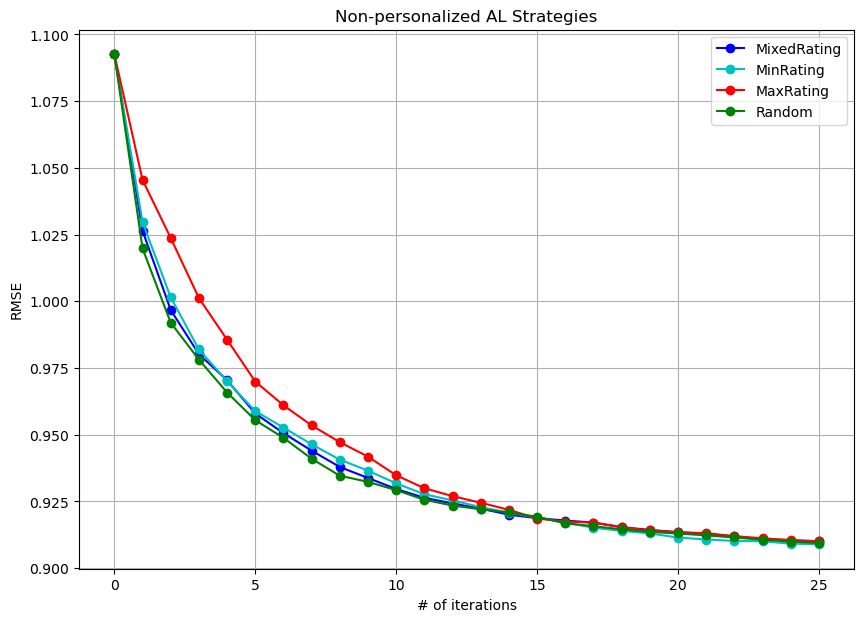

In [225]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o',  'm-o', 'y-o']

# y_axis = list(range(0, n_epochs+1))


for m, s in list(zip(marker_l, strtgs.keys())):
    ax.plot(list(range(0, len(strtgs[s]['rmse']))), strtgs[s]['rmse'], m, label=s)   

# ax.plot(list(range(0, len(strtgs[s]['rmse']))), [fin_acc]*len(list(range(0, len(strtgs[s]['rmse'])))),'-', label='all-tr')   
          
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
plt.title('Non-personalized AL Strategies')

plt.show()
# plt.savefig('./plots/NonPersolized-all-%score.png'%n_core, dpi=300)

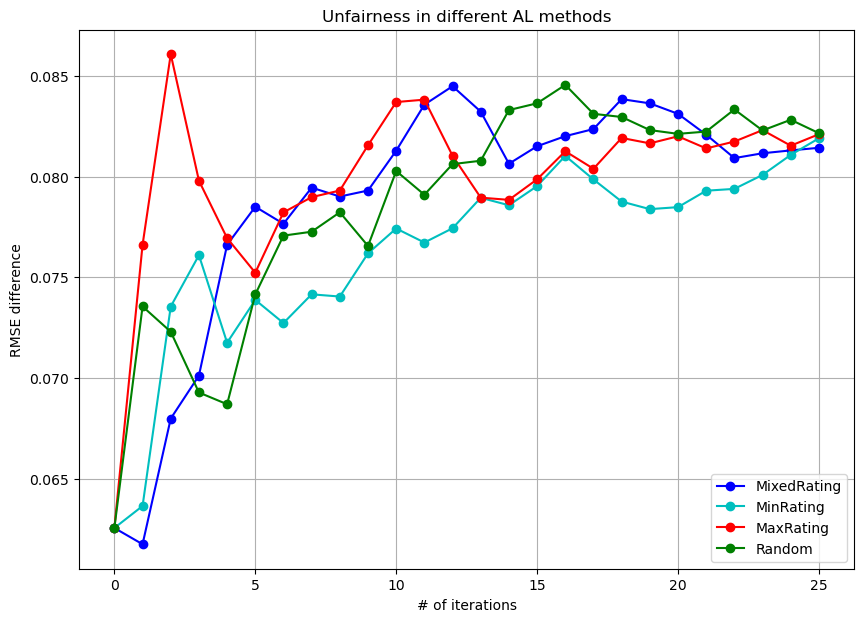

In [226]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o', 'y-o']

# y_axis = list(range(0, dataset.item_n, w))

for m, s in list(zip(marker_l, strtgs.keys())):
    
    rmse_diff = [a-b for a, b in zip(strtgs[s]['rmse_pro'], strtgs[s]['rmse_unpro'])]
    ax.plot(list(range(0, len(strtgs[s]['rmse']))), rmse_diff, m, label=s)
    # ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE difference')
plt.title('Unfairness in different AL methods')

plt.show()
# plt.savefig('./plots/rmse_diff_all_rmse_%score.png'%n_core, dpi=300)

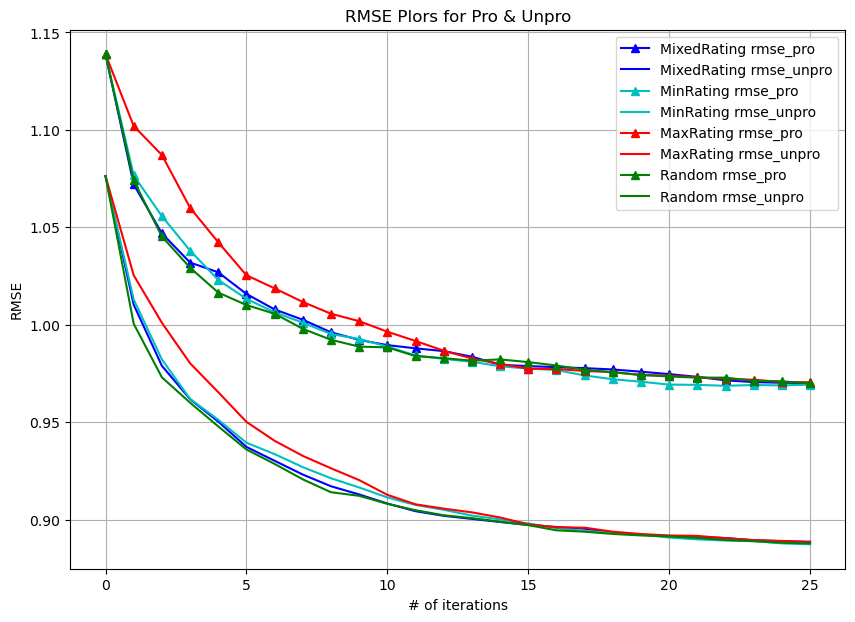

In [227]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-', 'y-']

# y_axis = list(range(0, dataset.item_n, w))
# list(range(0, len(results[i][1]['rmse'])))


for m, s in list(zip(marker_l, strtgs.keys())):
    
    ax.plot(list(range(0, len(strtgs[s]['rmse_pro']))), strtgs[s]['rmse_pro'], m+'^', label=s +' rmse_pro')
    ax.plot(list(range(0, len(strtgs[s]['rmse_unpro']))), strtgs[s]['rmse_unpro'], m, label=s +' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
plt.title('RMSE Plors for Pro & Unpro')
plt.show()
# plt.savefig('./plots/all_methods_sep_rmse_%score.png'%n_core, dpi=300)

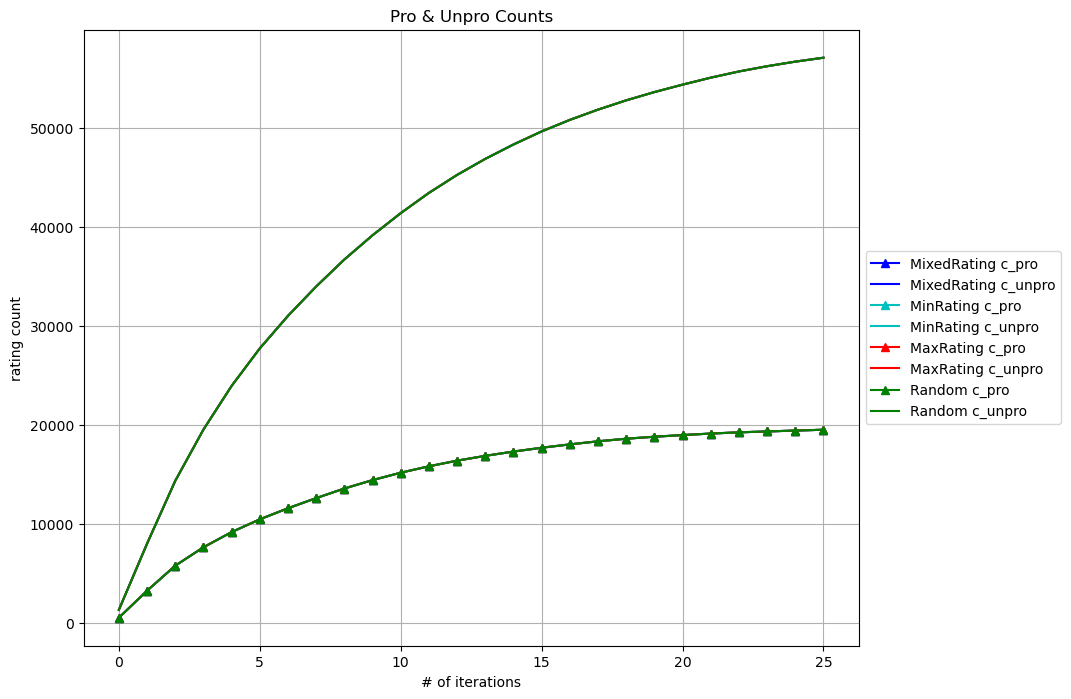

In [228]:
fig, ax = plt.subplots(figsize=(10, 8))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-', 'y-']


for m, s in list(zip(marker_l, strtgs.keys())):
    
    ax.plot(list(range(0, len(strtgs[s]['c_pro']))), strtgs[s]['c_pro'], m+'^', label=s+' c_pro')
    ax.plot(list(range(0, len(strtgs[s]['c_unpro']))), strtgs[s]['c_unpro'], m, label=s+' c_unpro')

           
ax.grid(True)
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

plt.xlabel('# of iterations')
plt.ylabel('rating count')
plt.title('Pro & Unpro Counts')
plt.show()
# plt.savefig('./plots/all_methods_sep_count_rmse_%score.png'%n_core, dpi=300)


# Plots - OLD

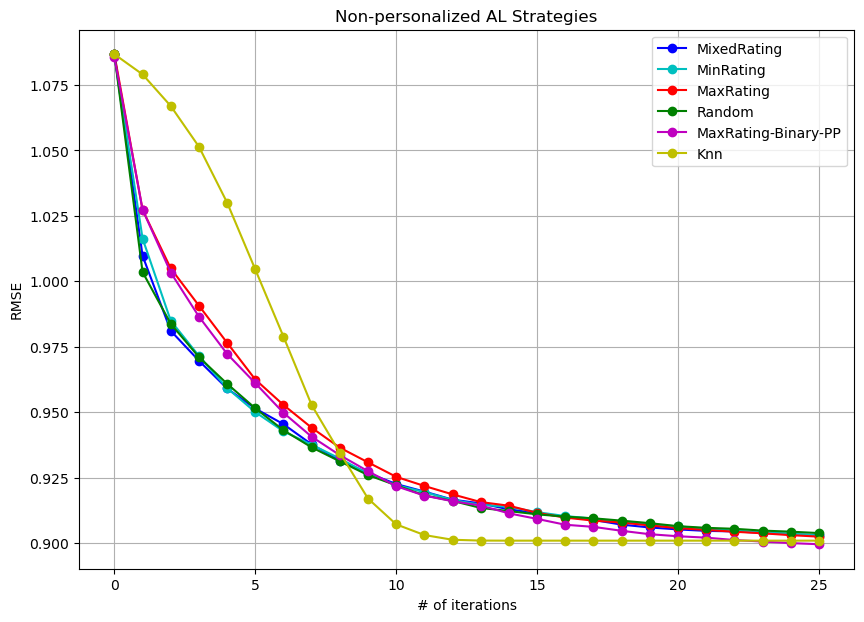

In [61]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o',  'm-o', 'y-o']

# y_axis = list(range(0, n_epochs+1))


for m, s in list(zip(marker_l, strtgs.keys())):
    ax.plot(list(range(0, len(strtgs[s]['rmse']))), strtgs[s]['rmse'], m, label=s)   

# ax.plot(list(range(0, len(strtgs[s]['rmse']))), [fin_acc]*len(list(range(0, len(strtgs[s]['rmse'])))),'-', label='all-tr')   
          
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
plt.title('Non-personalized AL Strategies')

plt.show()
# plt.savefig('./plots/NonPersolized-all-%score.png'%n_core, dpi=300)

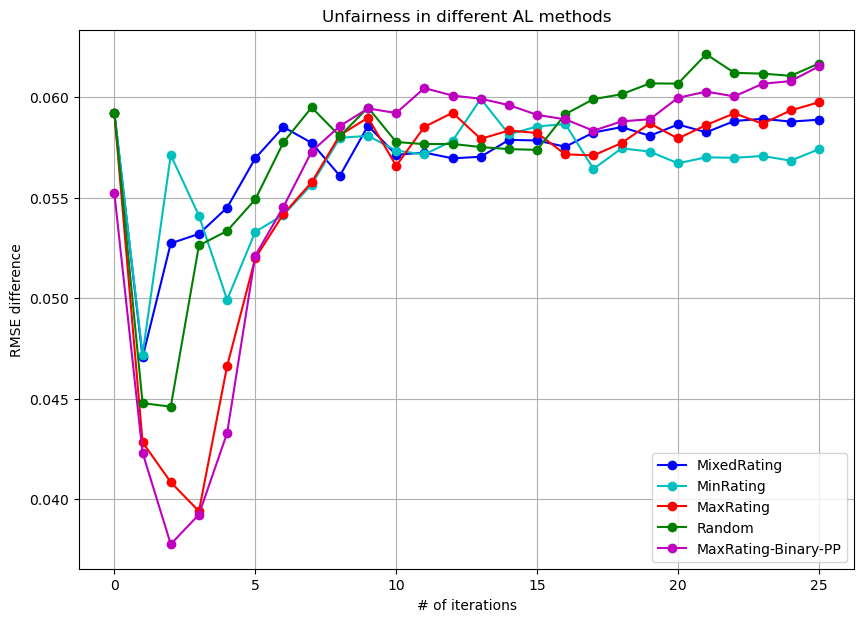

In [56]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o', 'y-o']

# y_axis = list(range(0, dataset.item_n, w))

for m, s in list(zip(marker_l, strtgs.keys())):
    
    rmse_diff = [a-b for a, b in zip(strtgs[s]['rmse_pro'], strtgs[s]['rmse_unpro'])]
    ax.plot(list(range(0, len(strtgs[s]['rmse']))), rmse_diff, m, label=s)
    # ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE difference')
plt.title('Unfairness in different AL methods')

plt.show()
# plt.savefig('./plots/rmse_diff_all_rmse_%score.png'%n_core, dpi=300)

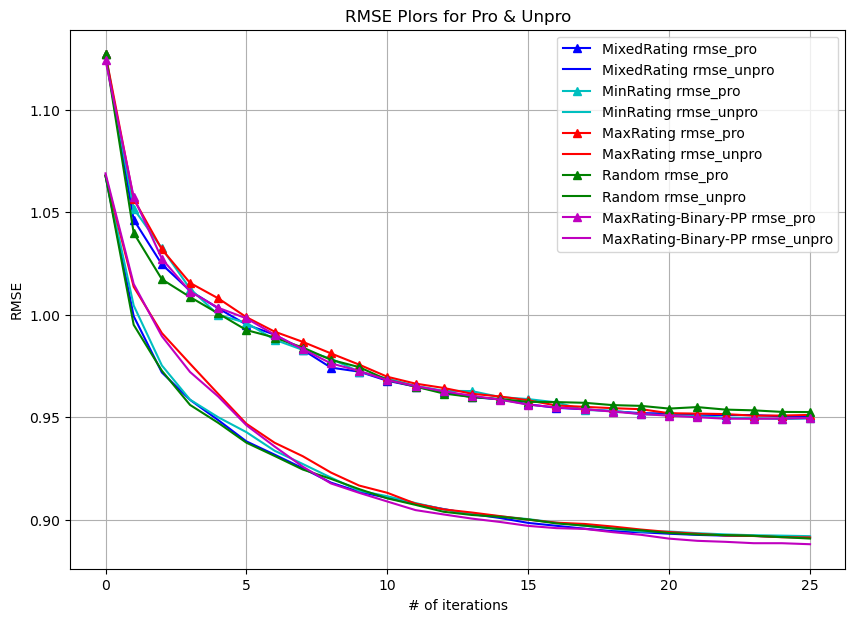

In [57]:
fig, ax = plt.subplots(figsize=(10,7))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-', 'y-']

# y_axis = list(range(0, dataset.item_n, w))
# list(range(0, len(results[i][1]['rmse'])))


for m, s in list(zip(marker_l, strtgs.keys())):
    
    ax.plot(list(range(0, len(strtgs[s]['rmse_pro']))), strtgs[s]['rmse_pro'], m+'^', label=s +' rmse_pro')
    ax.plot(list(range(0, len(strtgs[s]['rmse_unpro']))), strtgs[s]['rmse_unpro'], m, label=s +' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')
plt.title('RMSE Plors for Pro & Unpro')
plt.show()
# plt.savefig('./plots/all_methods_sep_rmse_%score.png'%n_core, dpi=300)

# pro & upro counts

In [64]:
list(strtgs.keys())

['MixedRating',
 'MinRating',
 'MaxRating',
 'Random',
 'MaxRating-Binary-PP',
 'Knn']

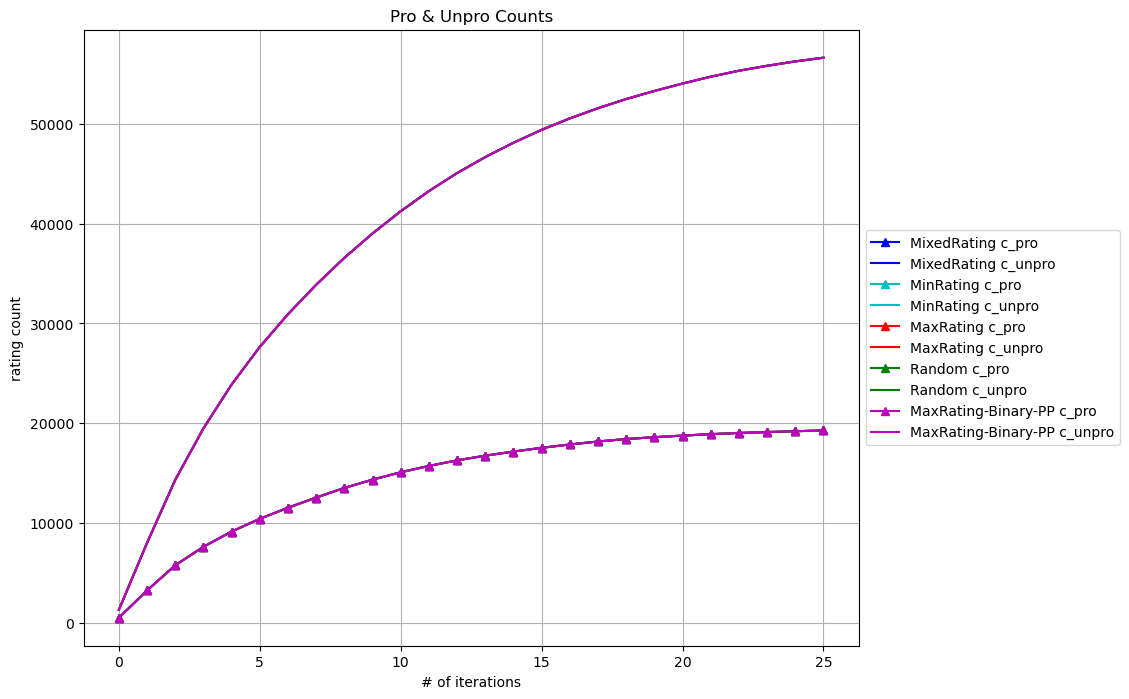

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-', 'y-']


for m, s in list(zip(marker_l, strtgs.keys())):
    
    ax.plot(list(range(0, len(strtgs[s]['c_pro']))), strtgs[s]['c_pro'], m+'^', label=s+' c_pro')
    ax.plot(list(range(0, len(strtgs[s]['c_unpro']))), strtgs[s]['c_unpro'], m, label=s+' c_unpro')

           
ax.grid(True)
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

plt.xlabel('# of iterations')
plt.ylabel('rating count')
plt.title('Pro & Unpro Counts')
plt.show()
# plt.savefig('./plots/all_methods_sep_count_rmse_%score.png'%n_core, dpi=300)
